# Natural Language Processing Feature Selection

In [3]:
# data manipulation libraries
import pandas as pd
import numpy as np

# custom project libraries
from utils.wine_review_utils import load_augmented_data, RATINGS

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_theme()

## Load Augmented Data

In [4]:
# focus on most reviewed variety from most reviewed country to accelerate the feature selection process
reviews = load_augmented_data()
pinot = reviews.query('variety == "Pinot Noir" and country == "US"')
pinot.info()
pinot.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8886 entries, 4 to 129967
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   winery              8886 non-null   object 
 1   variety             8886 non-null   object 
 2   year                8886 non-null   int64  
 3   country             8886 non-null   object 
 4   price               8860 non-null   float64
 5   taster_name         8886 non-null   object 
 6   description         8886 non-null   object 
 7   points              8886 non-null   int64  
 8   rating              8886 non-null   object 
 9   description_length  8886 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 763.6+ KB


winery     variety  year country  price     taster_name  \
4          Sweet Cheeks  Pinot Noir  2012      US   65.0    Paul Gregutt   
21              Acrobat  Pinot Noir  2013      US   20.0    Paul Gregutt   
25  Castello di Amorosa  Pinot Noir  2011      US   69.0  Virginie Boone   
35                Erath  Pinot Noir  2010      US   50.0    Paul Gregutt   
78                Z'IVO  Pinot Noir  2015      US   25.0    Paul Gregutt   

                                          description  points     rating  \
4   Much like the regular bottling from 2012, this...      87  very good   
21  A sleek mix of tart berry, stem and herb, alon...      87  very good   
25  Oak and earth intermingle around robust aromas...      87  very good   
35  As with many of the Erath 2010 vineyard design...      86       good   
78  Some rosés are made simply by bleeding the jui...      86       good   

    description_length  
4                  249  
21                 233  
25                 259  
35                 242  
78                 288

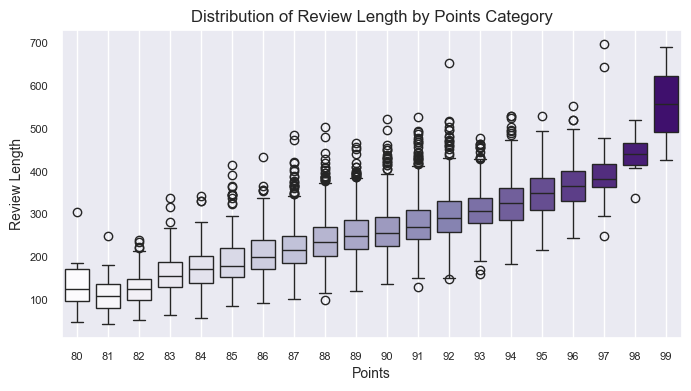

In [5]:
rating_order = ['acceptable', 'good', 'very good', 'excellent', 'superb', 'clasic']
plt.figure(figsize=(8,4))
sns.boxplot(x = 'points', y = 'description_length', palette = 'Purples', hue='points', data = pinot, native_scale=False, legend=None)
plt.title("Distribution of Review Length by Points Category for Pinot Noir Reviews", fontsize=12)
plt.xlabel("Points",fontsize=10)
plt.ylabel("Review Length",fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

**Timing Helper**

In [6]:
import time
from collections import namedtuple
from IPython.display import display, Markdown

PERF = namedtuple('PERF', ['algo', 'duration'])

timings = []

def timeit(algo, purpose, func, count, items='documents'):
  start = time.perf_counter()
  result = func()
  elapsed = time.perf_counter()-start
  timings.append(PERF(algo, elapsed))
  display(Markdown(f'It took ${elapsed/60:.1f}$ minutes to {purpose} for ${count:,d}$ {items}.'))
  return result

_time = lambda algo, purpose, func, count=pinot.shape[0], items='reviews': timeit(algo, purpose, func, count, items)

## Natural Language Processing Feature Comparison

### Bag-Of-Word and TF-IDF Vectors
The simplest scheme is to count the occurence of words in the reviews. The descriptions can be preprocessed to remove stop words, named entities, etc.

**Bag of Words Features**

In [7]:
import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

swords = stopwords.words('english') + ['year', 'years', 'wine', 'wines', 'country', 'variety']

vectorizer = CountVectorizer(stop_words=swords, min_df=.015, max_df=.95, token_pattern=r'\b[^\d\W]+\b')
bow = _time('BOW', 'calculate bag-of-words features', lambda: pd.DataFrame(vectorizer.fit_transform(pinot.description).toarray(), index=pinot.index, columns=vectorizer.get_feature_names_out()))
bow.info()
bow.sample(5, random_state=42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


It took $0.0$ minutes to calculate bag-of-words features for $8,886$ reviews.

<class 'pandas.core.frame.DataFrame'>
Index: 8886 entries, 4 to 129967
Columns: 328 entries, accented to young
dtypes: int64(328)
memory usage: 22.3 MB


accented  acidic  acidity  acids  across  add  age  aged  aging  \
127857         0       0        0      0       0    0    0     0      0   
30536          0       0        0      0       0    0    0     0      0   
76870          0       0        0      0       0    1    0     0      0   
12931          0       0        0      0       0    0    0     0      0   
103708         0       0        0      0       0    0    0     0      0   

        alcohol  ...  weight  well  wet  white  wild  winemaker  winery  \
127857        0  ...       0     0    0      0     0          0       0   
30536         0  ...       0     0    0      0     0          0       0   
76870         0  ...       0     0    0      0     0          0       0   
12931         0  ...       0     0    0      0     0          0       0   
103708        0  ...       0     0    0      0     0          0       0   

        wrapped  yet  young  
127857        0    0      0  
30536         0    0      0  
76870         0    0      0  
12931         0    0      0  
103708        0    0      0  

[5 rows x 328 columns]

**TF-IDF Features**

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=swords, min_df=.015, max_df=.95, token_pattern=r'\b[^\d\W]+\b')
tfidf = _time('TF-IDF', 'calculate TF-IDF features', lambda: pd.DataFrame(vectorizer.fit_transform(pinot.description).toarray(), index=pinot.index, columns=vectorizer.get_feature_names_out()))
tfidf.info()
tfidf.sample(5, random_state=42)

It took $0.0$ minutes to calculate TF-IDF features for $8,886$ reviews.

<class 'pandas.core.frame.DataFrame'>
Index: 8886 entries, 4 to 129967
Columns: 328 entries, accented to young
dtypes: float64(328)
memory usage: 22.3 MB


accented  acidic  acidity  acids  across       add  age  aged  aging  \
127857       0.0     0.0      0.0    0.0     0.0  0.000000  0.0   0.0    0.0   
30536        0.0     0.0      0.0    0.0     0.0  0.000000  0.0   0.0    0.0   
76870        0.0     0.0      0.0    0.0     0.0  0.253976  0.0   0.0    0.0   
12931        0.0     0.0      0.0    0.0     0.0  0.000000  0.0   0.0    0.0   
103708       0.0     0.0      0.0    0.0     0.0  0.000000  0.0   0.0    0.0   

        alcohol  ...  weight  well  wet  white  wild  winemaker  winery  \
127857      0.0  ...     0.0   0.0  0.0    0.0   0.0        0.0     0.0   
30536       0.0  ...     0.0   0.0  0.0    0.0   0.0        0.0     0.0   
76870       0.0  ...     0.0   0.0  0.0    0.0   0.0        0.0     0.0   
12931       0.0  ...     0.0   0.0  0.0    0.0   0.0        0.0     0.0   
103708      0.0  ...     0.0   0.0  0.0    0.0   0.0        0.0     0.0   

        wrapped  yet  young  
127857      0.0  0.0    0.0  
30536       0.0  0.0    0.0  
76870       0.0  0.0    0.0  
12931       0.0  0.0    0.0  
103708      0.0  0.0    0.0  

[5 rows x 328 columns]

**Custom Tokenizer BOW Features**

In [9]:
import spacy

nlp = spacy.load("en_core_web_lg")

def preprocess(doc):
  # drop punctuation, proper nouns, numbers and stop words
  keep = lambda token: (token[1] not in ['PUNCT','PROPN', 'NUM']) and (token[2] == 0)
  # run the preprocessing pipeline
  return (' '.join(map(lambda token: token[0], filter(keep, [(w.lemma_, w.pos_, w.is_stop) for w in nlp(doc)])))).strip()


In [10]:
from IPython.display import display, Markdown

description = pinot.sample(1, random_state=42).description.values[0]
display(Markdown(description))
display(Markdown(preprocess(description)))

Tight, light and layered in freshly baked bread and firm cherry and cranberry, this is a soft, rounded Pinot from an inland Sonoma Coast site that's balanced, food-friendly and ready to enjoy now through 2016.

tight light layer freshly baked bread firm cherry cranberry soft rounded inland site balanced food friendly ready enjoy

In [11]:
vectorizer = CountVectorizer(token_pattern=r'\b[^\d\W]+\b', preprocessor=preprocess)
bow_spacy = _time('spaCy BOW', 'calculate spaCy bag-of-words features', lambda: pd.DataFrame(vectorizer.fit_transform(pinot.description).toarray(), index=pinot.index, columns=vectorizer.get_feature_names_out()))
bow_spacy.drop('year', axis=1, inplace=True)
bow_spacy.info()
bow_spacy.sample(5, random_state=42)

It took $1.1$ minutes to calculate spaCy bag-of-words features for $8,886$ reviews.

<class 'pandas.core.frame.DataFrame'>
Index: 8886 entries, 4 to 129967
Columns: 6248 entries, Cuvée to zone
dtypes: int64(6248)
memory usage: 423.6 MB


Cuvée  Drew  Dry  Now  Sangiovese  Set  Woodsy  abandon  abbreviate  \
127857      0     0    0    0           0    0       0        0           0   
30536       0     0    0    0           0    0       0        0           0   
76870       0     0    0    0           0    0       0        0           0   
12931       0     0    0    0           0    0       0        0           0   
103708      0     0    0    0           0    0       0        0           0   

        aberrant  ...  zest  zestiness  zesty  zigzag  zing  zinge  zingy  \
127857         0  ...     0          0      0       0     0      0      0   
30536          0  ...     0          0      0       0     0      0      0   
76870          0  ...     0          0      0       0     0      0      0   
12931          0  ...     0          0      0       0     0      0      0   
103708         0  ...     0          0      0       0     0      0      0   

        zip  zippy  zone  
127857    0      0     0  
30536     0      0     0  
76870     0      0     0  
12931     0      0     0  
103708    0      0     0  

[5 rows x 6248 columns]

**Custom TF-IDF Tokenizer Features**

In [12]:
vectorizer = TfidfVectorizer(token_pattern=r'\b[^\d\W]+\b', preprocessor=preprocess)
tfidf_spacy = _time('spaCy TF-IDF', 'calculate spaCy TF-IDF features', lambda: pd.DataFrame(vectorizer.fit_transform(pinot.description).toarray(), index=pinot.index, columns=vectorizer.get_feature_names_out()))
tfidf_spacy.drop('year', axis=1, inplace=True)
tfidf_spacy.info()
tfidf_spacy.sample(5, random_state=42)

It took $1.1$ minutes to calculate spaCy TF-IDF features for $8,886$ reviews.

<class 'pandas.core.frame.DataFrame'>
Index: 8886 entries, 4 to 129967
Columns: 6248 entries, Cuvée to zone
dtypes: float64(6248)
memory usage: 423.6 MB


Cuvée  Drew  Dry  Now  Sangiovese  Set  Woodsy  abandon  abbreviate  \
127857    0.0   0.0  0.0  0.0         0.0  0.0     0.0      0.0         0.0   
30536     0.0   0.0  0.0  0.0         0.0  0.0     0.0      0.0         0.0   
76870     0.0   0.0  0.0  0.0         0.0  0.0     0.0      0.0         0.0   
12931     0.0   0.0  0.0  0.0         0.0  0.0     0.0      0.0         0.0   
103708    0.0   0.0  0.0  0.0         0.0  0.0     0.0      0.0         0.0   

        aberrant  ...  zest  zestiness  zesty  zigzag  zing  zinge  zingy  \
127857       0.0  ...   0.0        0.0    0.0     0.0   0.0    0.0    0.0   
30536        0.0  ...   0.0        0.0    0.0     0.0   0.0    0.0    0.0   
76870        0.0  ...   0.0        0.0    0.0     0.0   0.0    0.0    0.0   
12931        0.0  ...   0.0        0.0    0.0     0.0   0.0    0.0    0.0   
103708       0.0  ...   0.0        0.0    0.0     0.0   0.0    0.0    0.0   

        zip  zippy  zone  
127857  0.0    0.0   0.0  
30536   0.0    0.0   0.0  
76870   0.0    0.0   0.0  
12931   0.0    0.0   0.0  
103708  0.0    0.0   0.0  

[5 rows x 6248 columns]

### Sentence Embeddings

Sentence embeddings map text to vector quantities where the magnitude and direction of the vector representing the description captures the meaning of the reviews. For some NLP analyses, these tend to give better results than word counting techniques. See [embeddings primer](ref-embeddings.ipynb) for an overview of how embeddings represent semantic meaning as a vector space quantity, and how vector operations can be used to manipulate the semantic meanings represented by words and sentences.
**Sentence Embedding Features**

In [13]:
from sentence_transformers import SentenceTransformer

def compute_embeddings(corpus, model_name='all-MiniLM-L6-v2', trust_remote_code=False):
  # timing helper
  __t = lambda purpose, func: timeit(model_name, purpose, func, len(corpus), 'reviews')

  # calculate embeddings using a pretrained sentence transformer model
  model = SentenceTransformer(model_name, trust_remote_code=trust_remote_code)
  return __t('compute embeddings', lambda: model.encode(corpus, normalize_embeddings=True, show_progress_bar=True, device='mps'))

In [14]:
# minilm v2 embeddings - 384 dimensions
minilm_l6_embeddings = pd.DataFrame(compute_embeddings(pinot.description.to_list(), model_name='all-MiniLM-L6-v2'), index=pinot.index)
minilm_l6_embeddings.sample(5, random_state=42)

Batches:   0%|          | 0/278 [00:00<?, ?it/s]

It took $0.1$ minutes to compute embeddings for $8,886$ reviews.

0         1         2         3         4         5         6    \
127857  0.021963 -0.077164 -0.070270  0.007796 -0.013414 -0.076970  0.008301   
30536  -0.009012 -0.021843  0.011922 -0.018175 -0.023361  0.040750  0.027453   
76870  -0.052800 -0.059466 -0.024866  0.058997 -0.038840  0.006314  0.068598   
12931   0.021628 -0.099345 -0.045392  0.045187 -0.047133 -0.064371  0.043463   
103708  0.096024 -0.038540 -0.071334  0.001269  0.131101 -0.018643  0.007971   

             7         8         9    ...       374       375       376  \
127857 -0.020851 -0.023376 -0.005791  ...  0.069855  0.040945  0.065838   
30536   0.012558 -0.048256 -0.066279  ...  0.001078  0.049326 -0.058568   
76870  -0.017440  0.042154 -0.072861  ... -0.030069 -0.001596 -0.018525   
12931   0.047555  0.029892 -0.040409  ...  0.049106  0.054170  0.032298   
103708 -0.046027  0.020226 -0.036353  ... -0.043657 -0.065264  0.002626   

             377       378       379       380       381       382       383  
127857 -0.056697  0.055928  0.033502 -0.002994 -0.008105  0.001149  0.008520  
30536  -0.027805  0.018715  0.045434  0.027365 -0.099262  0.049139  0.008525  
76870   0.014994  0.022763  0.032813  0.111661 -0.029935  0.031561 -0.019789  
12931  -0.063441  0.063229  0.003646 -0.013197  0.006091  0.007237  0.023850  
103708 -0.015892  0.030095 -0.038918  0.073693 -0.039639  0.086119 -0.026826  

[5 rows x 384 columns]

In [15]:
# jina v2 embeddings - 512 dimensions
jinav2_embeddings = pd.DataFrame(compute_embeddings(pinot.description.to_list(), model_name='jinaai/jina-embeddings-v2-base-en'), index=pinot.index)
jinav2_embeddings.sample(5, random_state=42)

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

Batches:   0%|          | 0/278 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


It took $0.2$ minutes to compute embeddings for $8,886$ reviews.

0         1         2         3         4         5         6    \
127857 -0.018709  0.025659  0.030999 -0.008946  0.010159  0.016387 -0.021974   
30536  -0.025100  0.022649  0.020457  0.029895  0.010531 -0.009692 -0.047740   
76870  -0.018835  0.059262 -0.028813 -0.035518 -0.014662 -0.021300 -0.027743   
12931  -0.030514  0.016601 -0.011788  0.002339 -0.003571  0.024247 -0.002914   
103708 -0.011993  0.084432 -0.008747  0.025558  0.053667 -0.036546 -0.029554   

             7         8         9    ...       758       759       760  \
127857  0.021335  0.044267  0.031413  ...  0.034840  0.074407 -0.043983   
30536  -0.031099  0.061363  0.023552  ... -0.020130  0.079850  0.001301   
76870  -0.022475  0.038323  0.044266  ...  0.086731  0.019099 -0.031331   
12931   0.074020  0.007534  0.015341  ...  0.023872  0.071670 -0.096671   
103708  0.013628  0.004738 -0.044342  ...  0.048414  0.073809 -0.007602   

             761       762       763       764       765       766       767  
127857  0.018767 -0.003796 -0.039599 -0.031243 -0.022589  0.046465  0.059261  
30536   0.025350  0.029477 -0.009538 -0.066567 -0.009804  0.048844  0.039186  
76870   0.005413 -0.023855  0.029028 -0.044523 -0.042378  0.041077  0.034269  
12931  -0.044717  0.004542  0.063056 -0.032483 -0.014049 -0.037596 -0.019328  
103708  0.068190  0.001353  0.000412 -0.036981 -0.040039  0.063951  0.108828  

[5 rows x 768 columns]

In [16]:
# mpnet embeddings - 768 dimensions
mpnet_embeddings = pd.DataFrame(compute_embeddings(pinot.description.to_list(), model_name='all-mpnet-base-v2'), index=pinot.index)
mpnet_embeddings.sample(5, random_state=42)

Batches:   0%|          | 0/278 [00:00<?, ?it/s]

It took $0.2$ minutes to compute embeddings for $8,886$ reviews.

0         1         2         3         4         5         6    \
127857 -0.031729 -0.018878 -0.017823  0.018976 -0.068534 -0.019817 -0.071868   
30536   0.056395  0.000251 -0.018979 -0.002843 -0.036888  0.058617 -0.050121   
76870   0.031599  0.050641 -0.028139 -0.025703 -0.038639  0.046122 -0.094219   
12931   0.016124  0.017735 -0.013650  0.070180 -0.029066 -0.010115 -0.028874   
103708  0.002650  0.008468 -0.016274  0.016306 -0.101561  0.023471 -0.041930   

             7         8         9    ...       758       759       760  \
127857  0.021844 -0.033324  0.026518  ... -0.062802  0.021452 -0.032834   
30536   0.018101  0.037865  0.008958  ... -0.046555  0.049819  0.013038   
76870  -0.016840  0.000517  0.025540  ... -0.019470  0.017312 -0.018694   
12931   0.005356 -0.048221  0.015632  ... -0.078987  0.027472  0.000563   
103708  0.006669  0.070241 -0.020501  ... -0.079973 -0.020218 -0.006364   

             761       762       763       764       765       766       767  
127857 -0.003585  0.016968  0.063273 -0.039409 -0.012548  0.031028 -0.008897  
30536   0.015332  0.010974  0.049891 -0.018838  0.013606 -0.031943 -0.011012  
76870   0.012807 -0.009341  0.056866 -0.021308  0.036936 -0.009298 -0.037710  
12931   0.008199  0.028612  0.023018 -0.026382 -0.016197  0.065598  0.012019  
103708  0.004241 -0.041022  0.000653 -0.034976  0.012775  0.010535 -0.067415  

[5 rows x 768 columns]

In [17]:
# jina v3 embeddings - 1024 dimensions
jinav3_embeddings = pd.DataFrame(compute_embeddings(pinot.description.to_list(), model_name='jinaai/jina-embeddings-v3', trust_remote_code=True), index=pinot.index)
jinav3_embeddings.sample(5, random_state=42)

Batches:   0%|          | 0/278 [00:00<?, ?it/s]

It took $0.7$ minutes to compute embeddings for $8,886$ reviews.

0         1         2         3         4         5         6     \
127857  0.010086 -0.092832 -0.055934  0.083162 -0.043754 -0.042694 -0.030773   
30536   0.101157 -0.078456 -0.033844  0.001184 -0.019620 -0.058594 -0.008379   
76870   0.081681 -0.064193 -0.013258  0.052765  0.008664 -0.027431 -0.008945   
12931  -0.003828 -0.122240 -0.056825  0.067778 -0.008706 -0.038752 -0.028735   
103708  0.044605 -0.056108 -0.044555  0.035095 -0.003703 -0.022886 -0.035015   

            7         8         9     ...      1014      1015      1016  \
127857  0.123255 -0.014178  0.077884  ...  0.027128  0.012044 -0.022042   
30536   0.084066 -0.069911  0.001339  ...  0.037255  0.040036  0.002122   
76870   0.118162 -0.061448  0.027399  ...  0.019103  0.019556 -0.011683   
12931   0.111382 -0.016128  0.075794  ...  0.034573 -0.002214 -0.011822   
103708  0.084793 -0.002482  0.058274  ...  0.025311  0.033198 -0.007636   

            1017      1018      1019      1020      1021      1022      1023  
127857 -0.026745 -0.027746 -0.026154 -0.023126 -0.006415 -0.026305  0.028910  
30536  -0.018581 -0.023596  0.009458 -0.032530  0.006302 -0.044333  0.020012  
76870  -0.029190 -0.026022 -0.019966 -0.035498  0.028146 -0.067650  0.012887  
12931  -0.017312 -0.028135 -0.005302 -0.004999 -0.003483 -0.003092  0.024525  
103708 -0.047474 -0.023218 -0.009613 -0.046998 -0.009360 -0.036032  0.025098  

[5 rows x 1024 columns]

**Review Perf Data**

In [18]:
pd.DataFrame(minilm_l6_embeddings, index=pinot.index)

0         1         2         3         4         5         6    \
4      -0.031719  0.061518 -0.030641  0.015420 -0.034111  0.030671 -0.032406   
21      0.051970 -0.032144 -0.035426  0.062029  0.032091  0.012462 -0.021855   
25      0.034169 -0.088537  0.004360  0.028374  0.082764 -0.076606  0.044916   
35     -0.044093 -0.014005 -0.023235  0.037555  0.047558  0.051676  0.009382   
78     -0.019954 -0.043926  0.018877  0.034606  0.012296  0.041169  0.025696   
...          ...       ...       ...       ...       ...       ...       ...   
129872  0.023610 -0.036604  0.001149  0.065155 -0.039425  0.053046  0.117861   
129888 -0.044790 -0.122170  0.012630  0.012161  0.012159  0.039514  0.056915   
129912  0.017680 -0.020259 -0.067526  0.015317  0.016270  0.014245  0.032868   
129920 -0.002525 -0.104796  0.017126 -0.012828  0.035263  0.065968  0.052175   
129967  0.088524 -0.040394 -0.017840  0.037679  0.038280  0.083295 -0.060006   

             7         8         9    ...       374       375       376  \
4      -0.051424 -0.018782 -0.085505  ... -0.017992  0.058915 -0.058342   
21      0.003986  0.004738 -0.059902  ...  0.064335  0.018390  0.011142   
25     -0.055467  0.019181 -0.060429  ...  0.073456 -0.029105  0.005006   
35     -0.005559  0.022468 -0.027972  ... -0.012704  0.009546  0.001085   
78     -0.054271  0.039448 -0.070550  ... -0.028522  0.016321  0.020774   
...          ...       ...       ...  ...       ...       ...       ...   
129872 -0.011038  0.021001 -0.083286  ...  0.024327  0.044442 -0.010146   
129888 -0.056479  0.003788 -0.071300  ...  0.013518  0.004680  0.075199   
129912 -0.006497 -0.017920 -0.040009  ... -0.022978 -0.022225 -0.021548   
129920 -0.004700  0.005185 -0.050015  ... -0.020353  0.029253  0.048902   
129967  0.054655 -0.016432 -0.020780  ...  0.017050  0.025453  0.030412   

             377       378       379       380       381       382       383  
4      -0.020586  0.073731 -0.035804  0.004446  0.005601  0.018019 -0.039419  
21     -0.023835  0.024813 -0.019121  0.043475 -0.062726  0.076756  0.005655  
25     -0.048721  0.086268  0.010853  0.022053 -0.026667  0.010250 -0.032379  
35     -0.055616  0.032513  0.031684  0.011010  0.041149  0.157987 -0.039438  
78     -0.008231  0.022884  0.024285  0.038658 -0.001905  0.141072 -0.027819  
...          ...       ...       ...       ...       ...       ...       ...  
129872  0.004988  0.010248  0.083181  0.141504 -0.038492  0.049451 -0.061044  
129888 -0.047828 -0.001348  0.023972  0.010352 -0.038997  0.001536 -0.024658  
129912 -0.040943  0.084642 -0.019711  0.020168 -0.022574  0.086985 -0.070620  
129920  0.001327  0.022947 -0.035282  0.081571 -0.000105  0.031979  0.004003  
129967 -0.060406  0.003095 -0.029495  0.131670 -0.055187  0.095393 -0.028454  

[8886 rows x 384 columns]

In [19]:
# summary of duration in seconds by algorithm for generating features from descriptions
pd.DataFrame(timings)

algo   duration
0                                BOW   0.126121
1                             TF-IDF   0.126164
2                          spaCy BOW  67.049587
3                       spaCy TF-IDF  64.873646
4                   all-MiniLM-L6-v2   8.346860
5  jinaai/jina-embeddings-v2-base-en  10.935549
6                  all-mpnet-base-v2  10.695026
7          jinaai/jina-embeddings-v3  41.302664

**Visualize Feature Matrices**

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# compute t-SNE 2D dimension reduction to visualize the feature matrices
def tsne(embeddings, perplexity=10):
  # timing helper
  __t = lambda purpose, func: timeit('tsne', purpose, func, embeddings.shape[0], 'reviews')

  # perform dimensionsal reduction on features extracted by sentence transformers
  pca = PCA(n_components=50, random_state=42)
  tsne = TSNE(perplexity=perplexity, random_state=42, n_jobs=1)
  return __t('perform t-SNE dimension reduction on embeddings', lambda: tsne.fit_transform(pca.fit_transform(embeddings)))


In [21]:
from sklearn.cluster import MiniBatchKMeans

color_map = dict(
  sparkling='forestgreen',
  white='gold',
  rose='deeppink',
  red='darkred',
  dessert='dodgerblue',
)

def visualize_embeddings(tsne_result, dimensions, model_name='all-MiniLM-L6-v2', hue=None, clusters=None):

  fig, axes = plt.subplots(1,2, figsize=(10,4))
  # Create a scatter plot with colors based on rating
  sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], s=5, hue=hue, hue_order=None if hue is None else rating_order, palette=None if hue is None else 'turbo', ax=axes[0])
  axes[0].set_title(f'2D t-SNE Plot of {model_name} Embeddings with {dimensions:,d} dimensions')
  if hue is not None:
    axes[0].legend(title=None, loc='lower center', mode='expand', ncol=len(rating_order), frameon=False, fancybox=False, markerscale=5, 
              fontsize='small', bbox_to_anchor=(-.05,-0.05,1,1), title_fontsize='medium', handletextpad=.05)
  axes[0].axis("off")

  # create cluster plot
  sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], s=5, hue=clusters, ax=axes[1])
  axes[1].set_title(f'KMeans cluster of {model_name} Features')
  if hue is not None:
    axes[1].legend(title=None, loc='lower center', mode='expand', ncol=len(rating_order), frameon=False, fancybox=False, markerscale=5, 
              fontsize='small', bbox_to_anchor=(-.05,-0.05,1,1), title_fontsize='medium', handletextpad=.05)
  axes[1].axis("off")

  fig.tight_layout()
  plt.show()

In [22]:
# sum of squared error vs k
cluster = lambda feature_matrix: pd.Series(MiniBatchKMeans(n_clusters=len(RATINGS), init_size=1024, batch_size=2048, max_iter=100, random_state=42)
                                                  .fit(feature_matrix)
                                                  .predict(feature_matrix), name='cluster', index=feature_matrix.index
                                          ).to_frame()


**BOW**

It took $0.2$ minutes to perform t-SNE dimension reduction on embeddings for $8,886$ reviews.

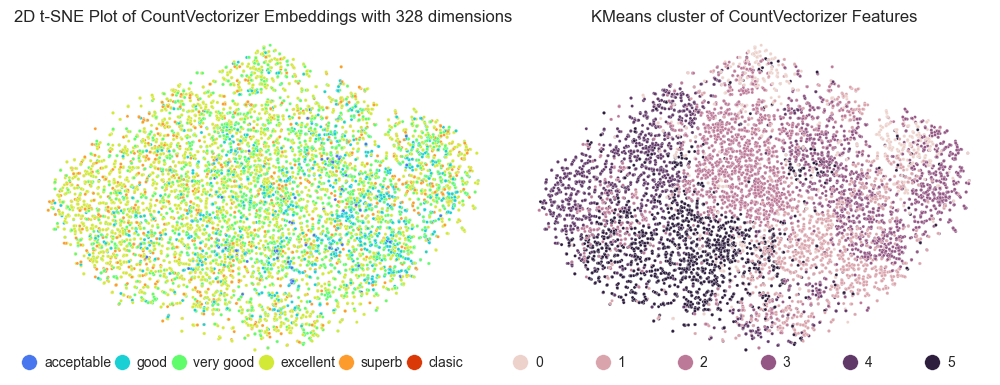

In [23]:
bow_tsne = tsne(bow)
visualize_embeddings(bow_tsne, bow.shape[1], model_name='CountVectorizer', hue=pinot.rating, clusters=cluster(bow).cluster)

**TF-IDF**

It took $0.2$ minutes to perform t-SNE dimension reduction on embeddings for $8,886$ reviews.

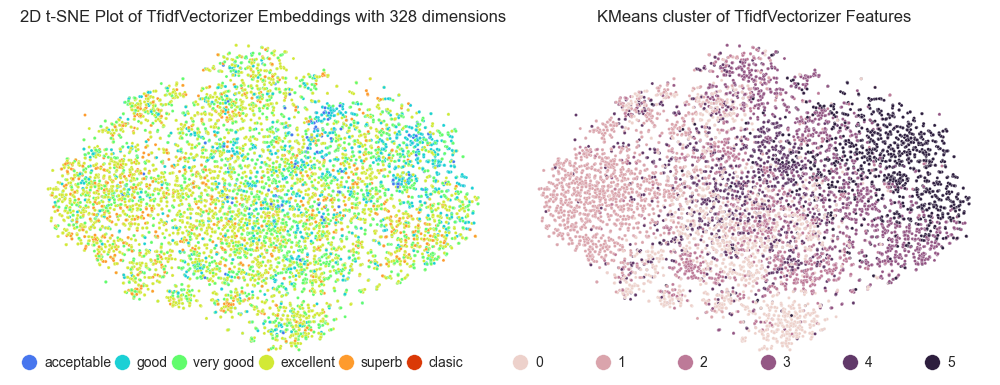

In [24]:
tfidf_tsne = tsne(tfidf)
visualize_embeddings(tfidf_tsne, tfidf.shape[1], model_name='TfidfVectorizer', hue=pinot.rating, clusters=cluster(tfidf).cluster)

**Custom Tokenizer BOW**

It took $0.2$ minutes to perform t-SNE dimension reduction on embeddings for $8,886$ reviews.

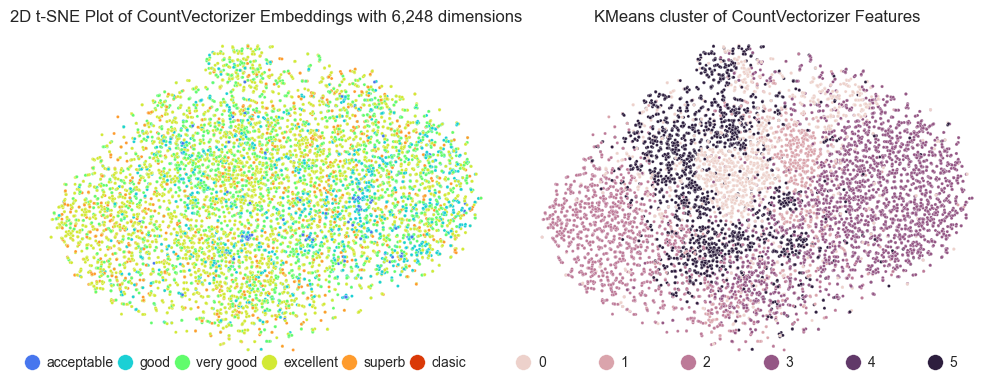

In [25]:
bow_spacy_tsne = tsne(bow_spacy)
visualize_embeddings(bow_spacy_tsne, bow_spacy.shape[1], model_name='CountVectorizer', hue=pinot.rating, clusters=cluster(bow_spacy).cluster)

**Custom Tokenizer TF-IDF**

It took $0.2$ minutes to perform t-SNE dimension reduction on embeddings for $8,886$ reviews.

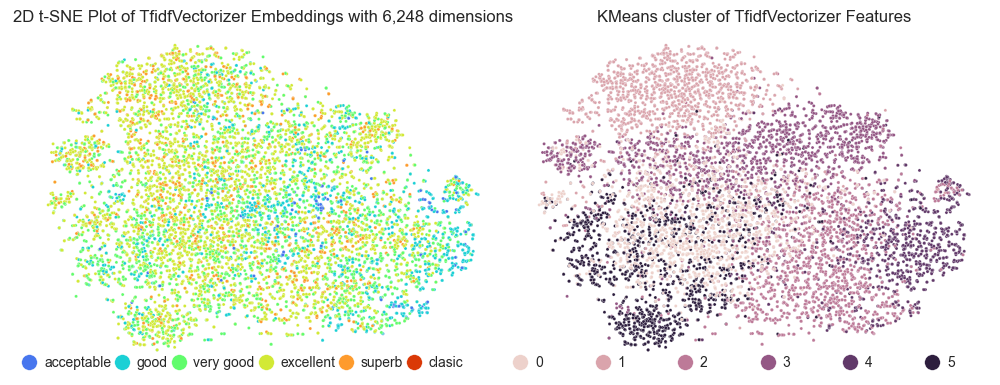

In [26]:
tfidf_spacy_tsne = tsne(tfidf_spacy)
visualize_embeddings(tfidf_spacy_tsne, tfidf_spacy.shape[1], model_name='TfidfVectorizer', hue=pinot.rating, clusters=cluster(tfidf_spacy).cluster)

**MiniLM Embeddings**

It took $0.2$ minutes to perform t-SNE dimension reduction on embeddings for $8,886$ reviews.

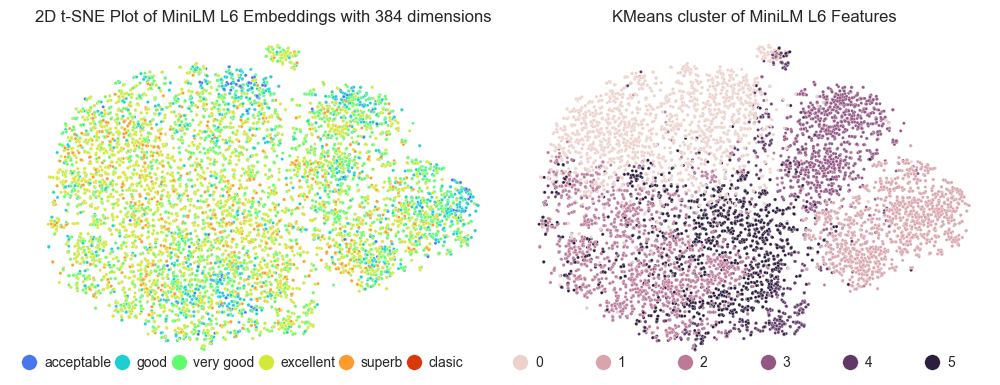

In [27]:
minilm_l6_tsne = tsne(minilm_l6_embeddings)
visualize_embeddings(minilm_l6_tsne, minilm_l6_embeddings.shape[1], model_name='MiniLM L6', hue=pinot.rating, clusters=cluster(minilm_l6_embeddings).cluster)

**Jina v2 Embeddings**

It took $0.2$ minutes to perform t-SNE dimension reduction on embeddings for $8,886$ reviews.

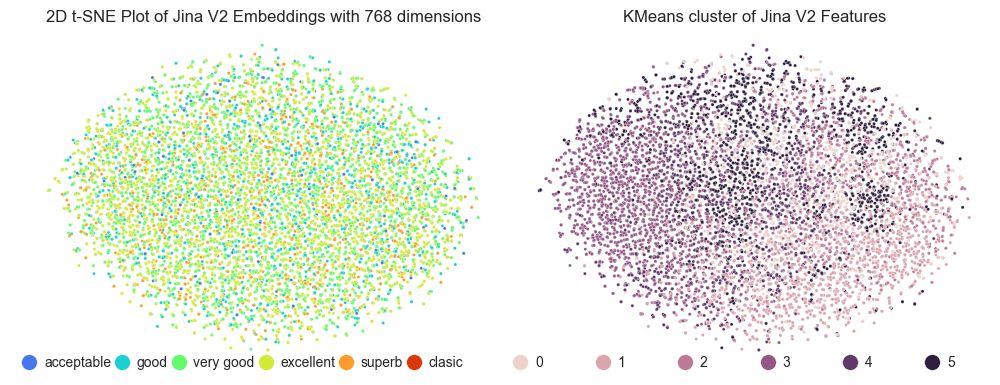

In [28]:
jinav2_tsne = tsne(jinav2_embeddings)
visualize_embeddings(jinav2_tsne, jinav2_embeddings.shape[1], model_name='Jina V2', hue=pinot.rating, clusters=cluster(jinav2_embeddings).cluster)

**MPNET Embeddings**

It took $0.2$ minutes to perform t-SNE dimension reduction on embeddings for $8,886$ reviews.

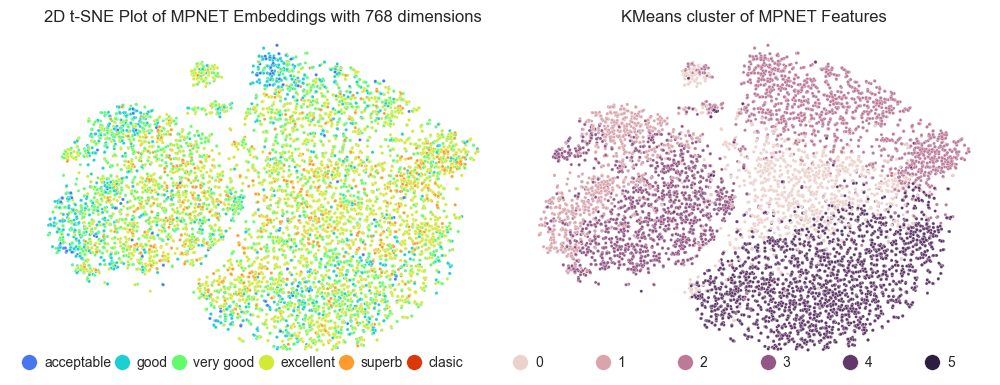

In [29]:
mpnet_tsne = tsne(mpnet_embeddings)
visualize_embeddings(mpnet_tsne, mpnet_embeddings.shape[1], model_name='MPNET', hue=pinot.rating, clusters=cluster(mpnet_embeddings).cluster)

**Jina v3 Embeddings**

It took $0.2$ minutes to perform t-SNE dimension reduction on embeddings for $8,886$ reviews.

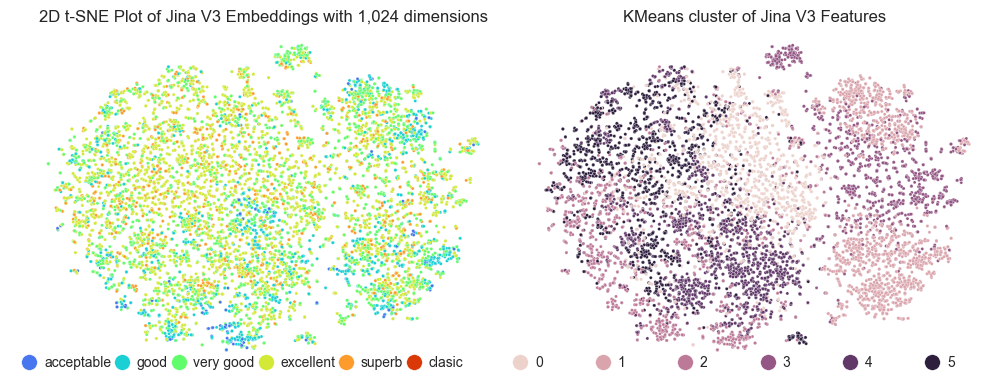

In [30]:
jinav3_tsne = tsne(jinav3_embeddings)
visualize_embeddings(jinav3_tsne, jinav3_embeddings.shape[1], model_name='Jina V3', hue=pinot.rating, clusters=cluster(jinav3_embeddings).cluster)

#### Conclusion
The MPNET model seems to be provide the best balance between capturing structure in the data, and compute time.

### Considering Tokens with Embeddings

The previous exercise calculated sentence embeddings on entire description. Let's see if calculating the embeddings on tokens helps accentuate the meaning of the reviews.

In [31]:
tokens = pinot.description.apply(preprocess)
tokens

4         like regular bottling come rough tannic rustic...
21        sleek mix tart berry stem herb hint oak chocol...
25        earth intermingle robust aroma wet forest floo...
35        vineyard designate strongly herbal note leaf h...
78        rosé simply bleed juice fermenter concentrate ...
                                ...                        
129872    like liquid cherry pie sweet medium bodied win...
129888    round red cherry deep plum ripe cranberry frui...
129912    block famous vineyard fleshy lushly layer wine...
129920    show clean citrus acid juiciness silky texture...
129967    citation give decade bottle age prior release ...
Name: description, Length: 8886, dtype: object

Batches:   0%|          | 0/278 [00:00<?, ?it/s]

It took $0.1$ minutes to compute embeddings for $8,886$ reviews.

It took $0.2$ minutes to perform t-SNE dimension reduction on embeddings for $8,886$ reviews.

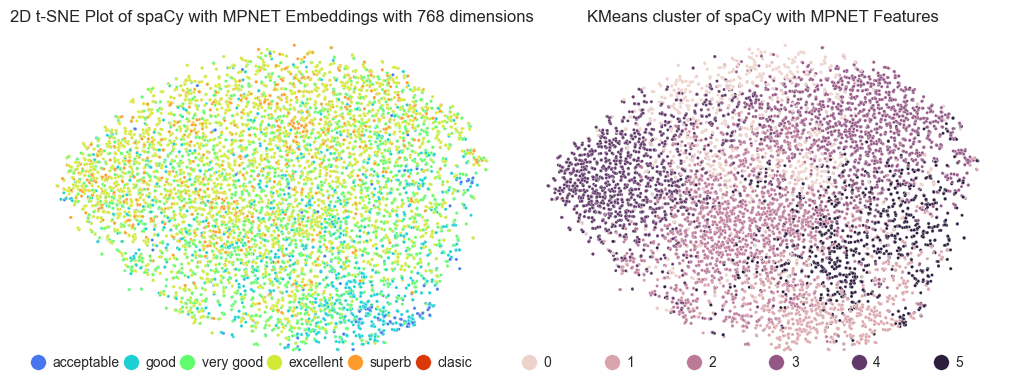

In [32]:
spacy_mpnet_embeddings = pd.DataFrame(compute_embeddings(tokens.to_list(), model_name='all-mpnet-base-v2'), index=pinot.index)
spacy_mpnet_tsne = tsne(spacy_mpnet_embeddings)
visualize_embeddings(spacy_mpnet_tsne, spacy_mpnet_embeddings.shape[1], model_name='spaCy with MPNET', hue=pinot.rating, clusters=cluster(spacy_mpnet_embeddings).cluster)

#### Conclusion

By inspection, the sentence embedding based on the full description appears to better capture structure in the reviews. We will not be using tokens.

## Next
- [Model Selection](model-selection.ipynb)